[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

This notebook is a short example of solving the advection-diffusion equation in 2D using PyMPDATA.

The initial condition is given by the following analytical formula at $t = 0$:
$$
z(x, y, t) = \sin(\omega(x - u_x t + y - u_y t)) \exp(-2 \mu t \omega^2) + 1
$$
The analytical solution can be derived from [here](https://rsmith.math.ncsu.edu/MA573_F17/Anal_Tech_Adv_Diff.pdf).
After the simulation, the final condition is compared with the analytical solution at $t = nt*dt$.
At the end a gif animation is created showing the evolution of the solution.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
from open_atmos_jupyter_utils import show_plot

In [20]:
import base64
import os
import tempfile
import numpy as np
from IPython.display import display, HTML
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic
from PyMPDATA_examples.utils import merge_images_into_gif

In [18]:
mu = 0.0005 # diffusion coefficient
dt = 0.025
tmax = 5.0
nt = int(tmax / dt)

nx = 32
ny = 32
ux  = 0.25
uy = 0.25

omega = np.pi

min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
Cx = ux * dt / dx
Cy = uy * dt / dy

In [5]:
opt = Options(n_iters=3, non_zero_mu_coeff=True)
boundary_conditions = (Periodic(), Periodic())

In [6]:
def analytic_solution(x, y, t):
    return np.sin(omega*(x-ux*t+y-uy*t))*np.exp(-2*mu*t*omega**2) + 1

In [7]:
def z(t):
    return np.array(
    [
        analytic_solution(x, y, t=t) for x in np.linspace(min_x, max_x, nx)
        for y in np.linspace(min_y, max_y, ny)
    ],
    dtype=float
).reshape((nx, ny))

advectee = ScalarField(data=z(t=0), halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [8]:
field_x = np.full((nx+1, ny), Cx, dtype=opt.dtype)
field_y = np.full((nx, ny+1), Cy, dtype=opt.dtype)

advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [9]:
stepper = Stepper(options=opt, n_dims=2)
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

In [10]:
vmin = np.min(solver.advectee.get())
vmax = np.max(solver.advectee.get())

In [11]:
def plot(*, data, title):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    ims = axs.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(ims, ax=axs)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_title(title)

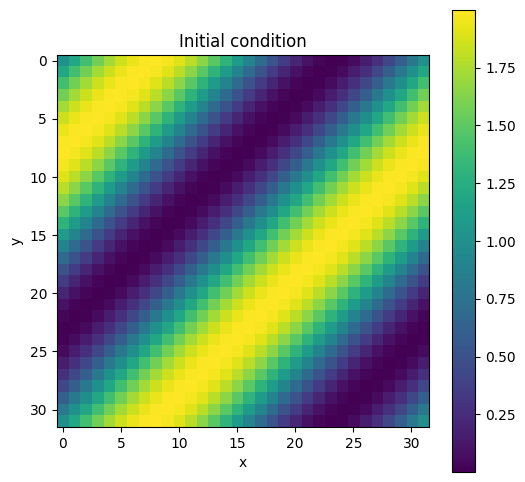

In [12]:
plot(
    data=solver.advectee.get().copy(),
    title='Initial condition'
)
show_plot("fig_1", inline_format='png')

In [13]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
for i in range(nt//10):
    solver.advance(n_steps=10, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / (nt//10)

FloatProgress(value=0.0, max=1.0)

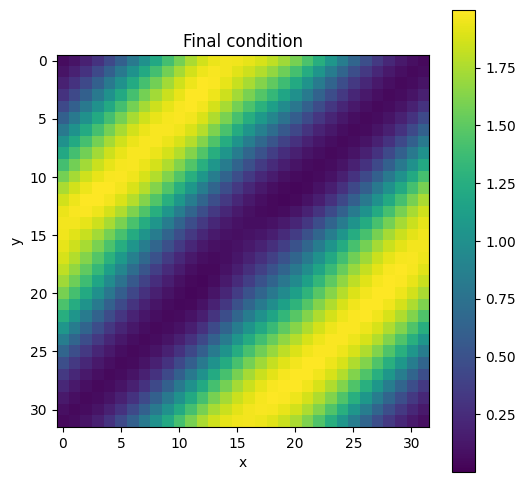

In [14]:
plot(
    data=solver.advectee.get().copy(),
    title='Final condition'
)
show_plot("fig_2", inline_format='png')

In [15]:
assert np.allclose(solver.advectee.get(), z(t=nt*dt), atol=0.25)


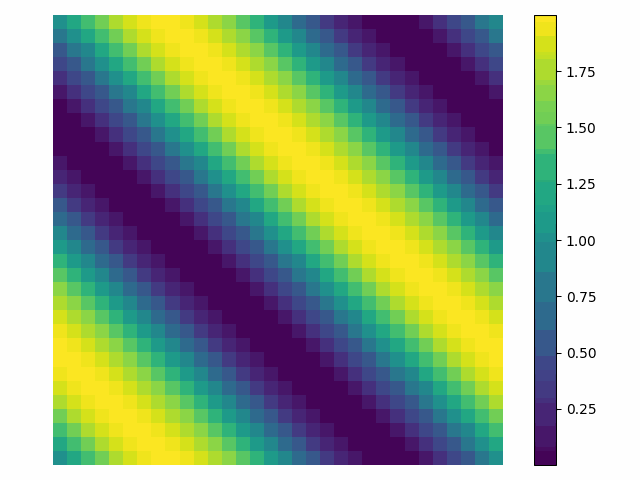

In [21]:
# TODO #480
with tempfile.TemporaryDirectory() as tmpdirname:
    for i, state in enumerate(states_history):
        state = np.flipud(state)
        plt.imshow(state, cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        plt.colorbar()
        plt.savefig(f"{tmpdirname}/frame_{i:03d}.png")
        plt.close()
    gif_path = f'{tmpdirname}/animation.gif'
    merge_images_into_gif(tmpdirname, gif_path)

    b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))